In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ANN learning libraries
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import scipy.stats as si
from scipy.stats import norm
from functools import partial
from scipy.optimize import minimize


In [2]:
# load simulated data
data = pd.read_csv("Data_SABR_vol_mult_rst.txt", header=None)
# data headings: [v, alpha, rho, imp vol 1-36]
data



,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0.54688,0.95751,-0.177200,0.50010,0.50161,0.50312,0.50463,0.50614,0.50765,0.48830,...,0.47926,0.48070,0.48213,0.48357,0.47594,0.47738,0.47882,0.48025,0.48169,0.48313
1,0.15761,0.97059,0.371910,0.48036,0.48141,0.48246,0.48350,0.48455,0.48559,0.48422,...,0.49471,0.49578,0.49685,0.49792,0.49470,0.49578,0.49685,0.49793,0.49901,0.50009
2,0.48538,0.80028,0.365730,0.38969,0.39290,0.39610,0.39931,0.40251,0.40572,0.39782,...,0.43103,0.43451,0.43800,0.44149,0.43184,0.43539,0.43894,0.44250,0.44605,0.44960
3,0.42176,0.91574,-0.286490,0.47646,0.47636,0.47626,0.47616,0.47607,0.47597,0.46509,...,0.44902,0.44893,0.44883,0.44874,0.44684,0.44675,0.44665,0.44656,0.44647,0.44638
4,0.95949,0.65574,0.233770,0.34376,0.35106,0.35837,0.36568,0.37299,0.38030,0.33534,...,0.38849,0.39642,0.40434,0.41226,0.38876,0.39702,0.40529,0.41355,0.42182,0.43008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85170,0.30682,0.69296,0.333960,0.33867,0.33996,0.34126,0.34255,0.34385,0.34514,0.34388,...,0.36158,0.36296,0.36433,0.36570,0.36319,0.36458,0.36596,0.36735,0.36874,0.37013
85171,0.60389,0.36030,-0.214600,0.21369,0.21488,0.21607,0.21725,0.21844,0.21962,0.19295,...,0.18273,0.18374,0.18474,0.18574,0.18505,0.18608,0.18711,0.18814,0.18916,0.19019
85172,0.70483,0.71981,-0.041396,0.38463,0.38828,0.39193,0.39557,0.39922,0.40287,0.37136,...,0.37793,0.38145,0.38496,0.38848,0.37586,0.37942,0.38299,0.38655,0.39012,0.39368
85173,0.12386,0.77258,0.026889,0.38661,0.38676,0.38692,0.38707,0.38722,0.38738,0.38650,...,0.38738,0.38753,0.38769,0.38784,0.38736,0.38751,0.38767,0.38782,0.38797,0.38813


In [3]:
# Separate inputs and targets
targets = data.iloc[:, 3:]
data = data.iloc[:, 0:3]
targets

,3,4,5,6,7,8,9,10,11,12,...,29,30,31,32,33,34,35,36,37,38
0,0.50010,0.50161,0.50312,0.50463,0.50614,0.50765,0.48830,0.48978,0.49125,0.49273,...,0.47926,0.48070,0.48213,0.48357,0.47594,0.47738,0.47882,0.48025,0.48169,0.48313
1,0.48036,0.48141,0.48246,0.48350,0.48455,0.48559,0.48422,0.48528,0.48633,0.48739,...,0.49471,0.49578,0.49685,0.49792,0.49470,0.49578,0.49685,0.49793,0.49901,0.50009
2,0.38969,0.39290,0.39610,0.39931,0.40251,0.40572,0.39782,0.40109,0.40436,0.40764,...,0.43103,0.43451,0.43800,0.44149,0.43184,0.43539,0.43894,0.44250,0.44605,0.44960
3,0.47646,0.47636,0.47626,0.47616,0.47607,0.47597,0.46509,0.46500,0.46490,0.46480,...,0.44902,0.44893,0.44883,0.44874,0.44684,0.44675,0.44665,0.44656,0.44647,0.44638
4,0.34376,0.35106,0.35837,0.36568,0.37299,0.38030,0.33534,0.34247,0.34960,0.35673,...,0.38849,0.39642,0.40434,0.41226,0.38876,0.39702,0.40529,0.41355,0.42182,0.43008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85170,0.33867,0.33996,0.34126,0.34255,0.34385,0.34514,0.34388,0.34520,0.34651,0.34783,...,0.36158,0.36296,0.36433,0.36570,0.36319,0.36458,0.36596,0.36735,0.36874,0.37013
85171,0.21369,0.21488,0.21607,0.21725,0.21844,0.21962,0.19295,0.19403,0.19510,0.19617,...,0.18273,0.18374,0.18474,0.18574,0.18505,0.18608,0.18711,0.18814,0.18916,0.19019
85172,0.38463,0.38828,0.39193,0.39557,0.39922,0.40287,0.37136,0.37489,0.37841,0.38193,...,0.37793,0.38145,0.38496,0.38848,0.37586,0.37942,0.38299,0.38655,0.39012,0.39368
85173,0.38661,0.38676,0.38692,0.38707,0.38722,0.38738,0.38650,0.38665,0.38681,0.38696,...,0.38738,0.38753,0.38769,0.38784,0.38736,0.38751,0.38767,0.38782,0.38797,0.38813


In [4]:
# split train and test set
train_inputs, test_inputs, train_targets, test_targets = train_test_split(
    data, targets, test_size=0.3, shuffle=False)

,3,4,5,6,7,8,9,10,11,12,...,29,30,31,32,33,34,35,36,37,38
59622,0.20760,0.20773,0.20787,0.20801,0.20814,0.20828,0.20843,0.20857,0.20870,0.20884,...,0.21202,0.21216,0.21229,0.21243,0.21284,0.21298,0.21312,0.21326,0.21340,0.21353
59623,0.19866,0.20074,0.20282,0.20490,0.20698,0.20906,0.19281,0.19483,0.19685,0.19886,...,0.22874,0.23109,0.23343,0.23578,0.23642,0.23889,0.24136,0.24384,0.24631,0.24878
59624,0.20624,0.20826,0.21028,0.21230,0.21432,0.21634,0.19611,0.19804,0.19996,0.20188,...,0.22066,0.22279,0.22491,0.22703,0.22695,0.22917,0.23139,0.23362,0.23584,0.23807
59625,0.37508,0.38270,0.39031,0.39792,0.40554,0.41315,0.37263,0.38019,0.38775,0.39532,...,0.42879,0.43716,0.44552,0.45389,0.42737,0.43604,0.44472,0.45339,0.46207,0.47074
59626,0.26691,0.26701,0.26711,0.26721,0.26731,0.26740,0.26801,0.26810,0.26820,0.26830,...,0.27062,0.27072,0.27082,0.27092,0.27105,0.27115,0.27125,0.27135,0.27145,0.27155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85170,0.33867,0.33996,0.34126,0.34255,0.34385,0.34514,0.34388,0.34520,0.34651,0.34783,...,0.36158,0.36296,0.36433,0.36570,0.36319,0.36458,0.36596,0.36735,0.36874,0.37013
85171,0.21369,0.21488,0.21607,0.21725,0.21844,0.21962,0.19295,0.19403,0.19510,0.19617,...,0.18273,0.18374,0.18474,0.18574,0.18505,0.18608,0.18711,0.18814,0.18916,0.19019
85172,0.38463,0.38828,0.39193,0.39557,0.39922,0.40287,0.37136,0.37489,0.37841,0.38193,...,0.37793,0.38145,0.38496,0.38848,0.37586,0.37942,0.38299,0.38655,0.39012,0.39368
85173,0.38661,0.38676,0.38692,0.38707,0.38722,0.38738,0.38650,0.38665,0.38681,0.38696,...,0.38738,0.38753,0.38769,0.38784,0.38736,0.38751,0.38767,0.38782,0.38797,0.38813


In [5]:
# save test inputs and targets for unseen testing
pd.DataFrame(test_inputs).to_csv("test_inputs_SABR_LS.csv")
pd.DataFrame(test_targets).to_csv("test_outputs_true_SABR.csv")

In [6]:
# scale inputs
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_inputs)
train_inputs = scaler.transform(train_inputs)
test_inputs = scaler.transform(test_inputs)


In [7]:
# convert to tensor
train_inputs = tf.convert_to_tensor(train_inputs, dtype='float64')
train_targets = tf.convert_to_tensor(train_targets.values, dtype='float64')
test_inputs = tf.convert_to_tensor(test_inputs, dtype='float64')
test_targets = tf.convert_to_tensor(test_targets.values, dtype='float64')


In [9]:
# Define the model
output_size = 36  
input_size = train_inputs.shape[1]

hidden_layer_size = 204

model = tf.keras.Sequential([
    tf.keras.layers.Dense(
        input_size, activation=tf.nn.relu),  # 1st hidden layer
    tf.keras.layers.Dense(
        hidden_layer_size, activation=tf.nn.relu),  # 2nd hidden layer
    tf.keras.layers.Dense(
        hidden_layer_size, activation=tf.nn.relu),  # 3rd Hidden layer
    tf.keras.layers.Dense(
        hidden_layer_size, activation=tf.nn.relu), # 4th Hidden layer
 
   tf.keras.layers.Dense(
        hidden_layer_size, activation=tf.nn.relu), # 5th Hidden layer

    tf.keras.layers.Dense(output_size, activation="linear")  # output layer

])


In [10]:
# set early stoppint criteria
LRScheduler = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=15,
                                verbose=1, min_delta=0.0001, cooldown=5, min_lr=0.00001)


In [11]:
# begin training
adam = Adam(lr=1e-02)

model.compile(optimizer=adam, loss="mse", metrics=["mean_absolute_error"])
batch_size = 16

max_epochs = 500

history = model.fit(train_inputs,  
                    train_targets, 
                    batch_size=batch_size,  
                    epochs=max_epochs,
                    validation_split=0.1,
                    callbacks=[
                        keras.callbacks.EarlyStopping(
                            monitor='val_loss', patience=40),
                        LRScheduler
                    ],
                    verbose=True)


C:\Users\Jenna\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/500


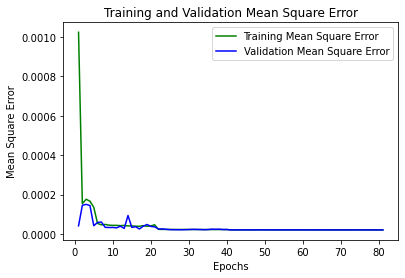

In [36]:
# plot mse train and validation across epochs
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(history.epoch)+1)
plt.plot(epochs, loss_train, 'g', label='Training Mean Square Error')
plt.plot(epochs, loss_val, 'b', label='Validation Mean Square Error')
plt.title('Training and Validation Mean Square Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Square Error')
plt.legend()
plt.show()


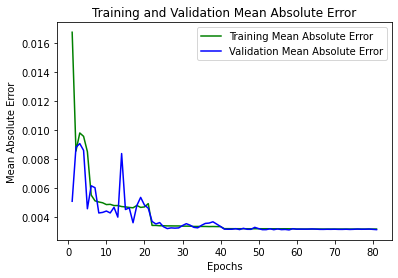

In [37]:
# plot mae train and validation across epochs
loss_train = history.history["mean_absolute_error"]
loss_val = history.history["val_mean_absolute_error"]
epochs = range(1, len(history.epoch)+1)
plt.plot(epochs, loss_train, 'g', label='Training Mean Absolute Error')
plt.plot(epochs, loss_val, 'b', label='Validation Mean Absolute Error')
plt.title('Training and Validation Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()


In [38]:
# strore predicted test vals
test_loss, test_mean_absolute_error = model.evaluate(
    test_inputs, test_targets, batch_size=1000)
pd.DataFrame(test_vals).to_csv("test_outputs_SABR_LS.csv")


26/26 [==============================] - 0s 9ms/step - loss: 2.0384e-05 - mean_absolute_error: 0.0032


In [39]:
# Save model
model_dir = 'impvolSABRModel.h5'
model.save(model_dir)

In [9]:
# import pre-trained model
from tensorflow.keras.models import load_model, save_model
calibration_model = tf.keras.models.load_model("impvolSABRModel.h5")


In [13]:
# time pre-trained model on 1000 samples
import time
test_size = test_targets.shape[0]
test_size
start = time.time()

s = (1000, output_size)
y_pred = np.zeros(s)
for i in range(1000):
    X_try = test_inputs[i, :]
    c = np.array([X_try])
    y_pred[i, :] = calibration_model.predict(c)

end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")


Runtime of the program is 132.50292253494263


In [49]:
# Store predicted values
pd.DataFrame(y_pred).to_csv("Pricing_SABR_impvol_pred.csv")


In [63]:
# save true targets
test_targets = test_targets.numpy()
test_targets_sub = test_targets[0:999, :]
test_targets_sub
pd.DataFrame(test_targets_sub).to_csv("Pricing_SABR_impvol_true.csv")
